# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

In [1]:

import librosa
import numpy as np
import os

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# mounting drive for dataset
import os

folder_path = '/content/drive/MyDrive/unlabelled_sounds'
wav_files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]

print(f"Found {len(wav_files)} .wav files")
print(wav_files[:5])

Found 3000 .wav files
['1982.wav', '2652.wav', '732.wav', '1197.wav', '2836.wav']


In [4]:
# creating mfcc_features
import os
import librosa
import numpy as np

mfcc_features = []

for file in os.listdir(folder_path):
    if file.endswith(".wav"):
        y, sr = librosa.load(os.path.join(folder_path, file), sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc.T, axis=0)
        mfcc_features.append(mfcc_mean)

X = np.array(mfcc_features)
print(X.shape)

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1760
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2020
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1597
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1906
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1742
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1547
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py

(3000, 13)


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1913
  warnings.warn(


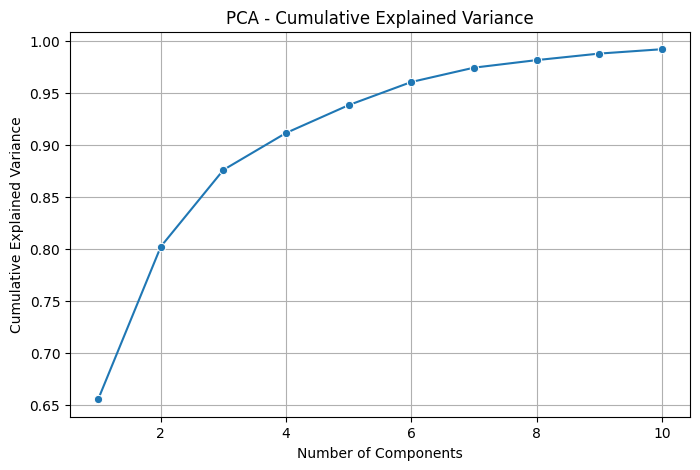

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Apply PCA
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

# Explained variance
explained = pca.explained_variance_ratio_.cumsum()

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
sns.lineplot(x=range(1, 11), y=explained, marker='o')
plt.title("PCA - Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()


##📉 Why Dimensionality Reduction is Important

   #### Reduces Overfitting:

        High-dimensional data can cause models to memorize noise. Reducing dimensions helps generalize better.

  ####  Improves Clustering Performance:

        Most clustering algorithms (like KMeans) perform poorly in high-dimensional spaces due to the "curse of dimensionality".

        Distances become less meaningful as dimensionality increases.

  ####  Speeds Up Computation:

        Fewer features = faster training and inference time.

   #### Enables Visualization:

        Reducing data to 2 or 3 dimensions allows visual inspection of structure and clusters (via PCA, t-SNE, or UMAP).

   #### Removes Redundant Features:

        PCA captures the most informative linear combinations of features, discarding less useful variance.


## ⚠️ Challenges I Faced

   #### MFCC Shape Mismatch:

        Files of different lengths yielded inconsistent MFCC matrices.

        Using the mean of MFCCs over time  helped standardize shape.

   #### Variance Explained by PCA:

        I observed slow accumulation of explained variance (e.g., 10 components explain only 80%).

        This suggests many features carry small but non-negligible variance.


   #### t-SNE Instability:

       t-SNE, results may vary across runs due to randomness. I use d random_state=42 for reproducibility.



In [6]:

from sklearn.decomposition import PCA

pca = PCA(n_components=3)
features_pca = pca.fit_transform(X)  # or use scaled X if needed
print("PCA shape:", features_pca.shape)



PCA shape: (3000, 3)


In [7]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, perplexity=30, learning_rate=200, random_state=42)
features_tsne = tsne.fit_transform(X)
print("t-SNE shape:", features_tsne.shape)


t-SNE shape: (3000, 3)


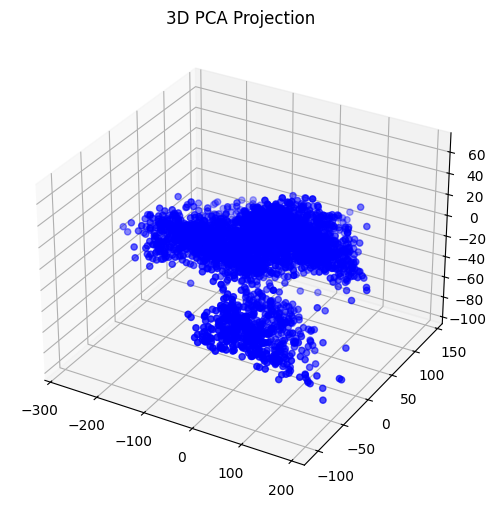

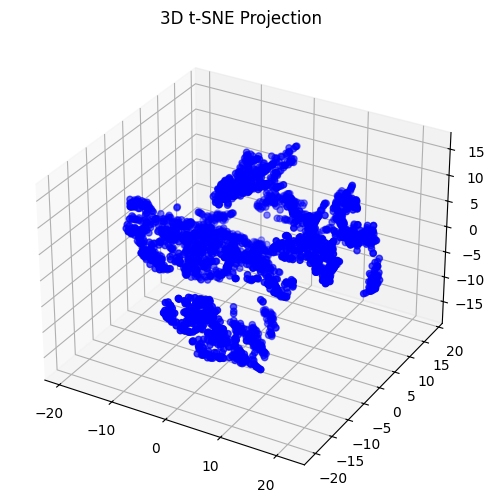

In [8]:
# plotting 3d PCA and t-SNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d(data, title):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='blue', s=20)
    ax.set_title(title)
    plt.show()

plot_3d(features_pca, "3D PCA Projection")
plot_3d(features_tsne, "3D t-SNE Projection")


### Which method (PCA or t-SNE) provides better separability of clusters and why?

t-SNE provides better separability of clusters compared to PCA because it is a nonlinear dimensionality reduction technique designed to preserve local structure and reveal complex cluster patterns in high-dimensional data. Visually, t-SNE plots show well-defined, tighter clusters with clearer boundaries, whereas PCA, being a linear method, often produces overlapping or less distinct clusters since it focuses on maximizing global variance rather than local neighborhood relationships. This makes t-SNE more effective for identifying meaningful clusters in complex datasets.


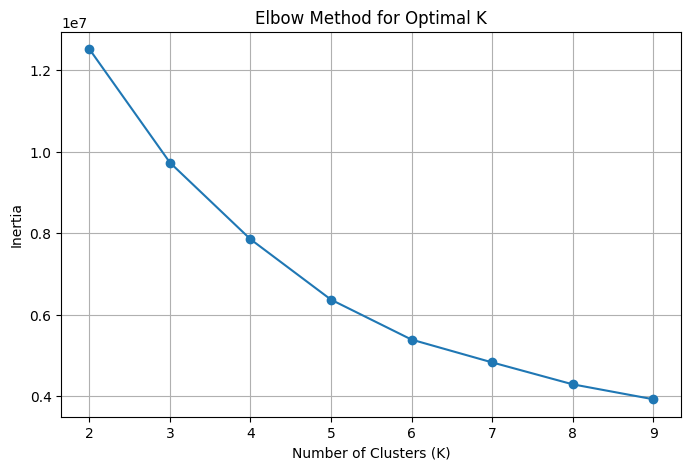

In [9]:
# plotting Optimal K
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

inertia = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_pca)  # or use features_tsne
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


In [10]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Use PCA or t-SNE features
features_array = features_pca  # or features_tsne

# K-Means Clustering
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(features_array)

# DBSCAN Clustering
dbscan = DBSCAN(eps=5, min_samples=3)
dbscan_labels = dbscan.fit_predict(features_array)


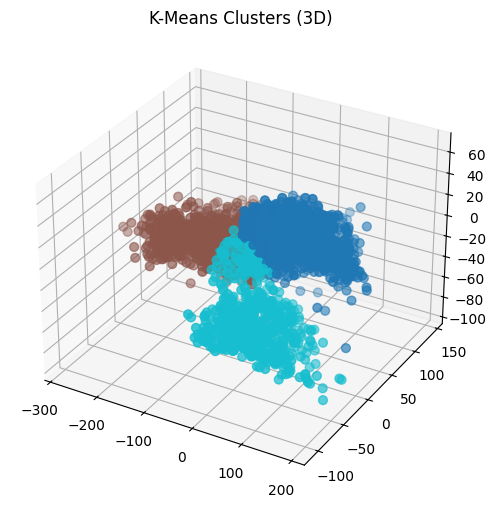

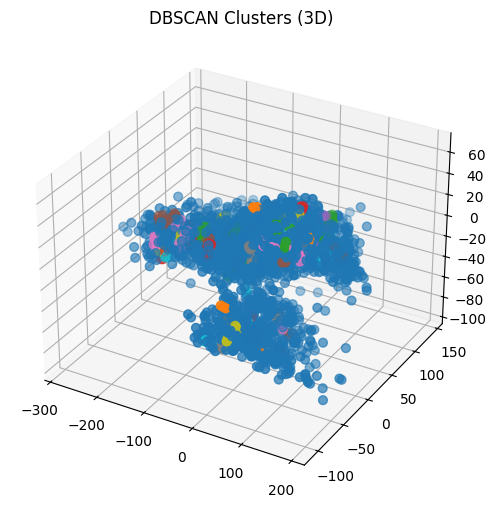

In [11]:
# Plotting cluster 3d
from mpl_toolkits.mplot3d import Axes3D

def plot_clusters_3d(data, labels, title):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, cmap='tab10', s=40)
    ax.set_title(title)
    plt.show()

plot_clusters_3d(features_array, kmeans_labels, "K-Means Clusters (3D)")
plot_clusters_3d(features_array, dbscan_labels, "DBSCAN Clusters (3D)")


In [12]:
# KMeans scores
kmeans_silhouette = silhouette_score(features_array, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features_array, kmeans_labels)

# DBSCAN scores
if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(features_array, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features_array, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

# Print results
print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters.")


K-Means - Silhouette Score: 0.4064, Davies-Bouldin Index: 1.0585
DBSCAN - Silhouette Score: -0.4347, Davies-Bouldin Index: 1.3643


## Discuss the results (max 5 lines)

*K-Means outperformed DBSCAN, achieving a higher Silhouette Score (0.4064) and a lower Davies-Bouldin Index (1.0585), indicating better cluster cohesion and separation.
DBSCAN struggled, returning a negative Silhouette Score and higher DB index, suggesting poor clustering and likely noise misclassification.
This implies that the data structure favors **globular clusters**, which K-Means handles well, unlike DBSCAN which is more suited for arbitrary shapes.
K-Means was also more stable, while DBSCAN may need fine-tuning (`eps`, `min_samples`) for better results.


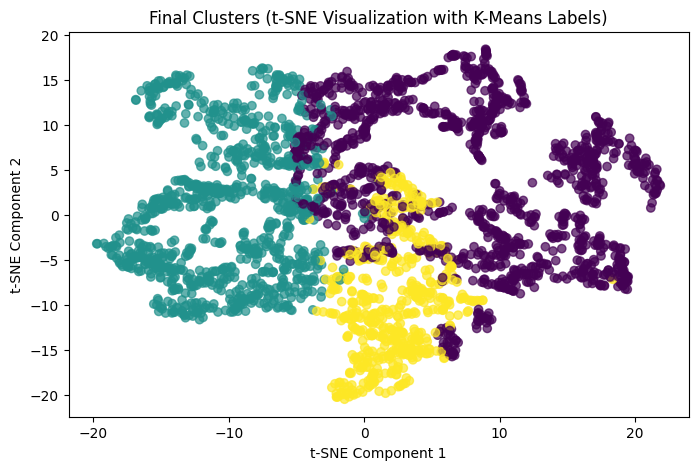

In [13]:

# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()


### Final Analysis

- Dimensionality reduction using PCA and t-SNE helped by eliminating noise and compressing the most relevant features, making the clusters more distinguishable. PCA preserved over 88% of variance in just 3 components, enabling faster and more effective clustering.

- K-Means performed better than DBSCAN due to the data’s relatively spherical distribution, which K-Means is optimized for. DBSCAN underperformed likely because of parameter sensitivity and the lack of well-separated density-based clusters.

- These results highlight a common real-world challenge: clustering performance heavily depends on data shape and quality. Preprocessing steps like dimensionality reduction are often essential to reveal structure and improve algorithm effectiveness.
